In [ ]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

# **Importing Tensorflow and setting up gpu**

In [ ]:
# std dependencies
import cv2
import os
import uuid
import random
import numpy as np
from matplotlib import pyplot as plt
# opencv, op syst,

In [ ]:
#import tensorflow dependencies
#**tensorflow functional api

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
# Layer is high level class and it helps us to define custom layer -- class L1Dist(Layer)
# Input allows us to define what we are passing through our model --Input(shape = )
# Flatten takes info from the previous layer and flatens it down to a single dimension/ cnn dat to dense pool
# conv2D is stand. convolutional layer
# MaxPool2D takes max out of a region
import tensorflow as tf

In [ ]:
                                                      # to avoid oom errors by setting gpu memory consumption growth
                                                      # to limit how much vram tensorflow is going to use
                                                      # IF YOU ARE USING IT ON A GPU MACHINE ONLY
gpus = tf.config.experimental.list_physical_devices('GPU')
                                                      # getting all gpu available on machine
for gpu in gpus:
                                                      # looping through all gpu
  tf.config.experimental.set_memory_growth(gpu, True)
                                                      # setting memory growth by function

# **Setting up folders, can be done manually as well**

In [ ]:
#setup paths
#POS_PATH = os.path.join('data', 'positive')
POS_PATH = '/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/positive'
#NEG_PATH = os.path.join('data', 'negative')
NEG_PATH = '/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/negative'
# al neg data we will take from a repository called labelled faces in the wild 
#ANC_PATH = os.path.join('data', 'anchor')
ANC_PATH ='/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/anchor'
# we will take from webcam

# top level/big folder data has 3 parts 

#os.path.join  joins different directories together to a full file path

In [ ]:
POS_PATH

'/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/positive'

# **load and preprocess the data, that is, gathering of training data**

In [ ]:
# take samples to load to data pipeline
anchor = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/anchor'+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/positive'+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files('/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/negative'+'/*.jpg').take(300)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

b'/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/anchor/2230498f-b98b-11ed-b659-088fc37921de.jpg'


In [ ]:
#  define preprocess method / function

def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [ ]:
img = preprocess('/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/anchor/e5db4eac-b98b-11ed-824a-088fc37921de.jpg')

In [ ]:
img.numpy().max() 

1.0

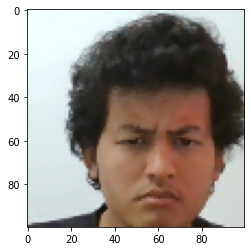

In [ ]:
plt.imshow(img)

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

# .zip allows to iterate through all three at a time

In [ ]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
samples = data.as_numpy_iterator()

exampple = samples.next()


exampple

(b'/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/anchor/4f0cfd41-b98b-11ed-8f96-088fc37921de.jpg',
 b'/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/positive/5598f40e-b98c-11ed-8e8b-088fc37921de.jpg',
 1.0)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*exampple)

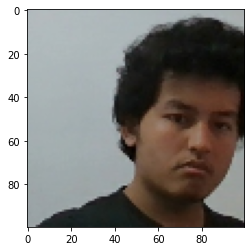

In [ ]:
plt.imshow(res[1])

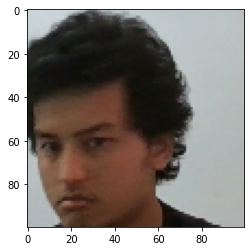

In [ ]:
plt.imshow(res[0])

In [ ]:
res[2]

1.0

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# **Training and testing partitions**

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# **Making of the layers of our model**

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')

In [ ]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)


NameError: ignored

# **Model, without implementing the siamese network layer and distance layer**

In [ ]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

# **Same model, Different method**

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

# **Making the siamese layer and distance layer**

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
l1 = L1Dist()

l1 #(anchor_embedding, validation_embedding)

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:
siamese_layer = L1Dist()

distances = siamese_layer(inp_embedding, val_embedding)

classifier = Dense(1, activation='sigmoid')(distances)

classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# **The Final Model to be used**

In [ ]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
test_batch = train_data.as_numpy_iterator()

batch_1 = test_batch.next()

X = batch_1[:2]
y = batch_1[2]


y

array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

# **Training our model**

In [ ]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 275

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/275
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 17s 216ms/step

 Epoch 2/275
27/27 [==============================] - 5s 203ms/step

 Epoch 3/275
27/27 [==============================] - 5s 205ms/step

 Epoch 4/275
27/27 [==============================] - 5s 199ms/step

 Epoch 5/275
27/27 [==============================] - 5s 199ms/step

 Epoch 6/275
27/27 [==============================] - 5s 197ms/step

 Epoch 7/275
27/27 [==============================] - 5s 194ms/step

 Epoch 8/275
27/27 [==============================] - 5s 193ms/step

 Epoch 9/275
27/27 [==============================] - 5s 192ms/step

 Epoch 10/275
27/27 [==============================] - 5s 192ms/step

 Epoch 11/275
27/27 [==============================] - 5s 195ms/step

 Epoch 12/275
27/27 [==============================] - 5s 192ms/step

 Epoch 13/275

**Testing**

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat=siamese_model.predict([test_input,test_val])
y_hat

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]

In [ ]:
y_true


array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

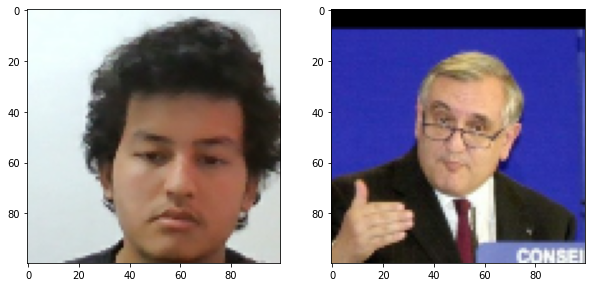

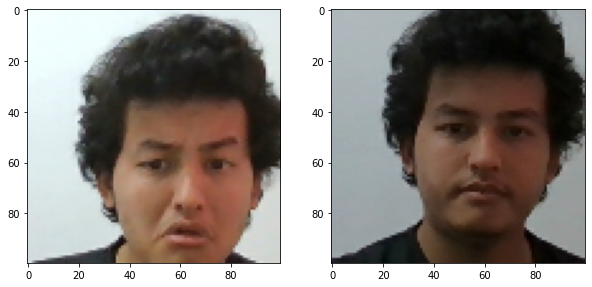

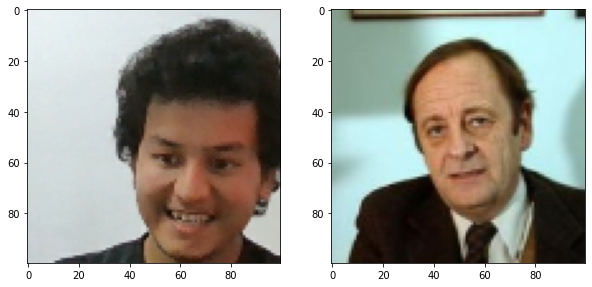

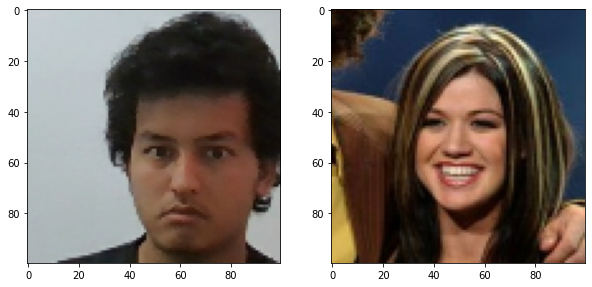

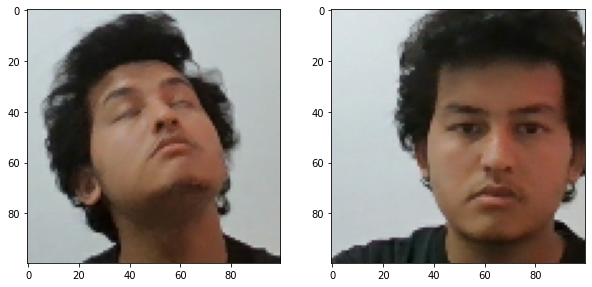

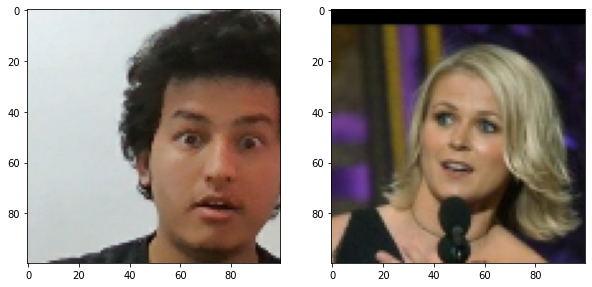

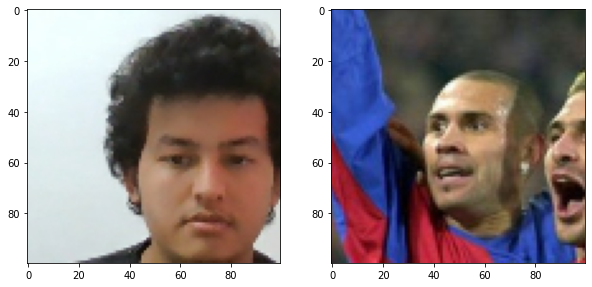

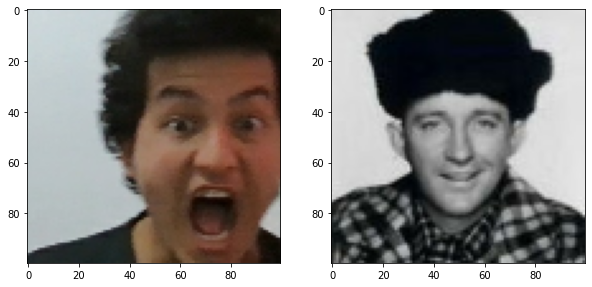

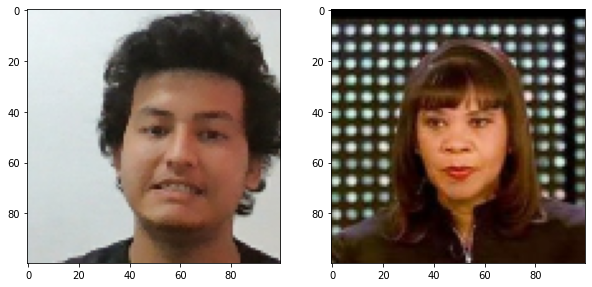

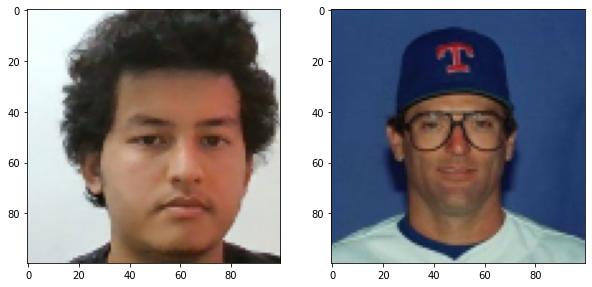

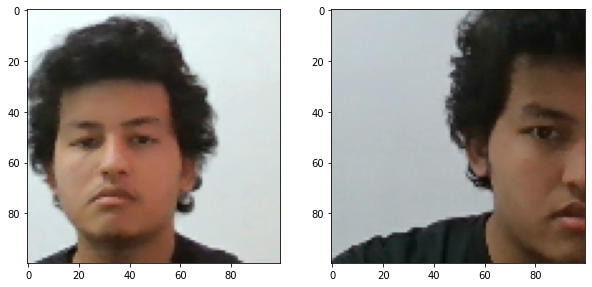

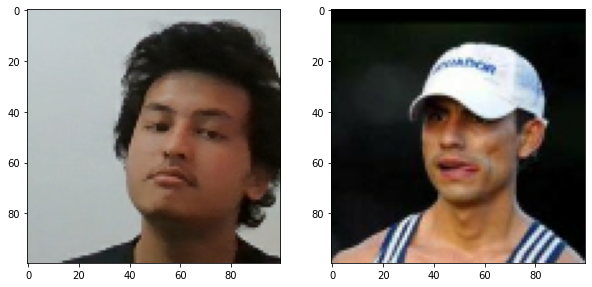

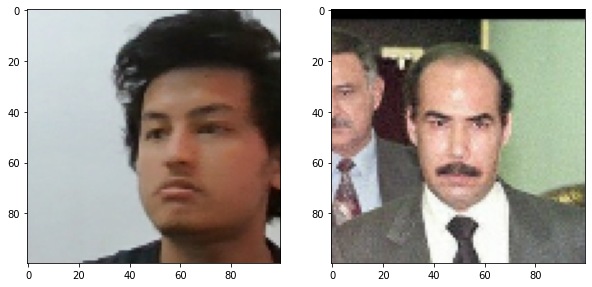

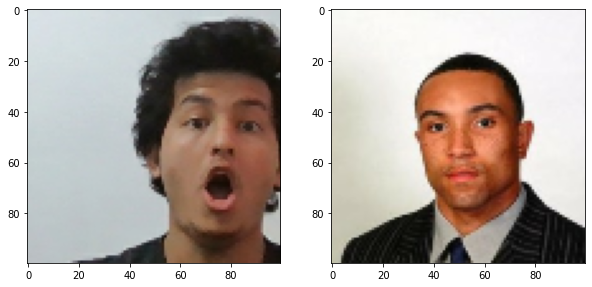

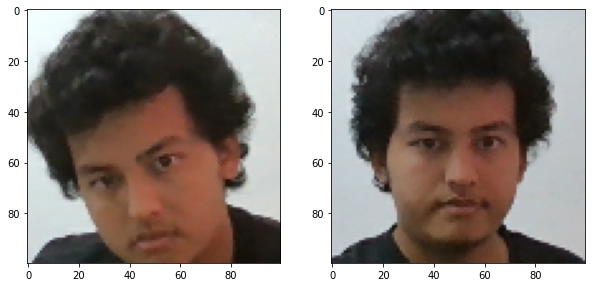

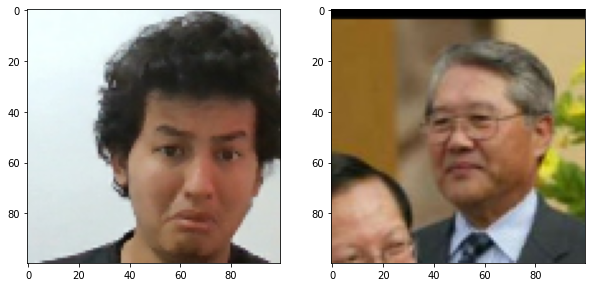

In [ ]:
for i in range(16):
  #plot size
  plt.figure(figsize=(10,8))
  #row,col,img index for subplot
  #subplot 1
  plt.subplot(1,2,1)
  plt.imshow(test_input[i])
  #subplot2
  plt.subplot(1,2,2)
  plt.imshow(test_val[i])
  #render img
  plt.show()


**Saving our model**

In [ ]:
siamese_model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Save weights
siamese_model.save('/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/siamesemodel.h5')



In [ ]:
L1Dist

__main__.L1Dist

In [ ]:
# Reload model 
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/imagerecognition/data/siamesemodel.h5', 
                                    custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 204ms/step


array([[3.9037205e-09],
       [1.0000000e+00],
       [3.6287215e-06],
       [8.5346688e-11],
       [9.9999964e-01],
       [8.3512597e-10],
       [9.3559460e-10],
       [4.2145211e-06],
       [2.6732683e-10],
       [1.4572593e-09],
       [1.0000000e+00],
       [3.2703605e-07],
       [1.5827553e-08],
       [2.3040384e-07],
       [1.0000000e+00],
       [5.7798077e-10]], dtype=float32)

In [ ]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# REAL TIME TEST

verification function

In [ ]:
#for image in os.listdir(os.path.join('/content','drive','MyDrive','Colab Notebooks','imagerecognition','verification_data','verification_images')):
   # validation_img = os.path.join('/content','drive','MyDrive','Colab Notebooks','imagerecognition','verification_data','verification_images',image)
   # print(validation_img)

In [ ]:
def verify(siamese_model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('/content','drive','MyDrive','Colab Notebooks','imagerecognition','verification_data','verification_images')):
    #   input_img = preprocess(os.path.join('/content','drive','MyDrive','Colab Notebooks','imagerecognition','verification_data','input_images','input_img.jpg'))
        input_img = preprocess('face.jpg')  
        validation_img = preprocess(os.path.join('/content','drive','MyDrive','Colab Notebooks','imagerecognition','verification_data','verification_images', image))
        
        # Make Predictions 
        result = siamese_model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('/content','drive','MyDrive','Colab Notebooks','imagerecognition','verification_data','verification_images'))) 
    verified = verification > verification_threshold

    print(detection)
    
    return results, verified

OpenCV real time verification

In [ ]:
import cv2

In [ ]:
  from google.colab.patches import cv2_imshow

In [ ]:
#Built-in Code for webcam access

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

name 'take_photo' is not defined


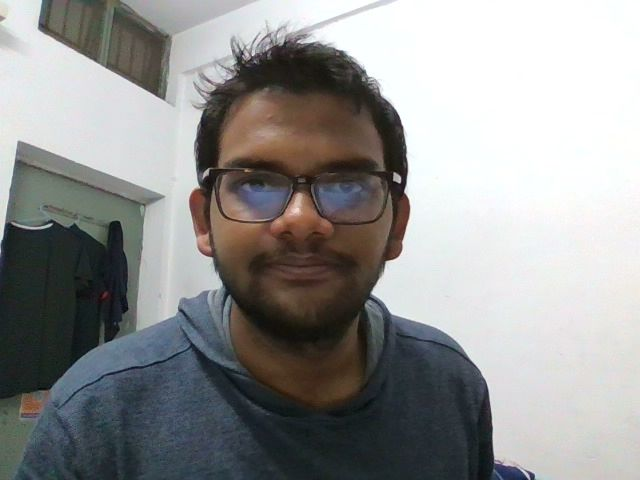

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

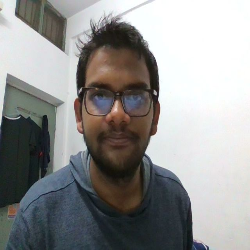

True

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

images = cv2.imread('photo.jpg')

image_resize = cv2.resize(images, (250, 250))

cv2_imshow(image_resize)

#cv2.imwrite(images, image_resize)==> you should use like this format (img='face.jpg'---> cv2.imwrite(img,image_resize))

cv2.imwrite('face.jpg', image_resize) # you can use directly

In [ ]:
#Detection threshold and verification threshold are freely alterable
results,verified = verify(model, 0.99, 0.8)
print(verified)
#Prints how many verifications the input image has passed, and the result
    

1/1 [==============================] - 0s 35ms/step
35
False


**There is another effective way to build our model, that will end up taking less time to train. We can take the average or the RMS of the r,g,b values passed for each image,and thus reduce the parameters.Then by using cnn layers, the only requirements become our face shape, and not shade or lighting or such external factors.(effectively we take a Black&White image, somewhat) **

Not done due to coming up with the idea late

<IPython.core.display.Javascript object>

Saved to photo.jpg


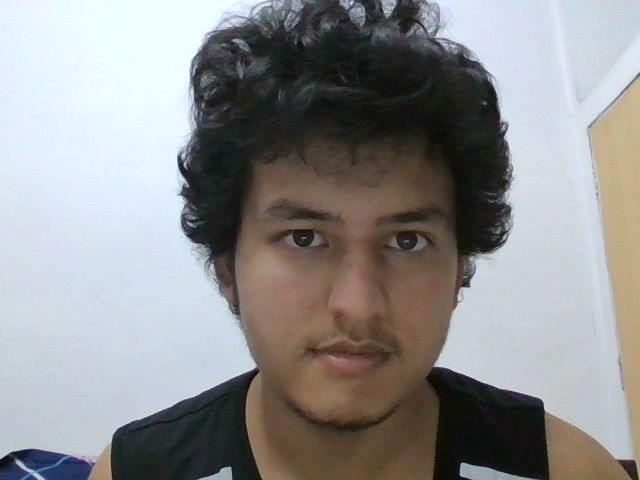

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

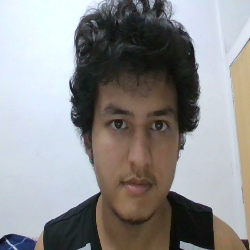

True

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

images = cv2.imread('photo.jpg')

image_resize = cv2.resize(images, (250, 250))

cv2_imshow(image_resize)

#cv2.imwrite(images, image_resize)==> you should use like this format (img='face.jpg'---> cv2.imwrite(img,image_resize))

cv2.imwrite('face.jpg', image_resize) # you can use directly

In [ ]:
#Detection threshold and verification threshold are freely alterable
results,verified = verify(model, 0.99, 0.8)
print(verified)
#Prints how many verifications the input image has passed, and the result

1/1 [==============================] - 0s 20ms/step
56
True


<IPython.core.display.Javascript object>

Saved to photo.jpg


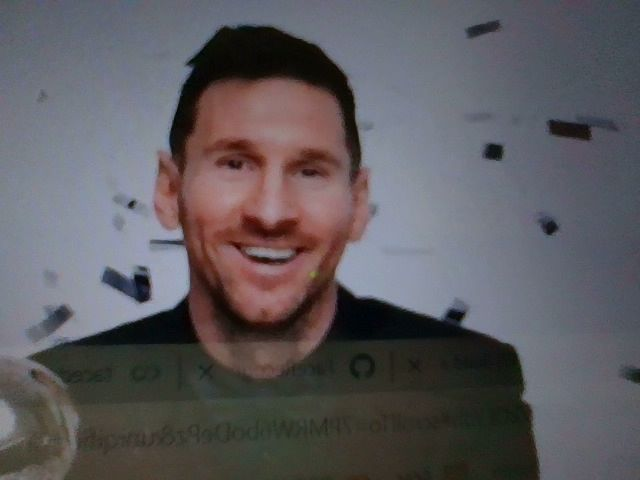

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


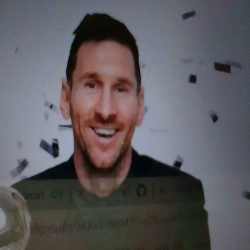

True

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

images = cv2.imread('photo.jpg')

image_resize = cv2.resize(images, (250, 250))

cv2_imshow(image_resize)

#cv2.imwrite(images, image_resize)==> you should use like this format (img='face.jpg'---> cv2.imwrite(img,image_resize))

cv2.imwrite('face.jpg', image_resize) # you can use directly

In [ ]:
#Detection threshold and verification threshold are freely alterable
results,verified = verify(model, 0.99, 0.8)
print(verified)
#Prints how many verifications the input image has passed, and the result

1/1 [==============================] - 0s 23ms/step
1
False
